This model is designed for predicting the price of the Norwegian Krone (NOK) compared to the American Dollar (USD). We have utilized a Long Short-Term Memory (LSTM) neural network, a type of recurrent neural network, to analyze and forecast the currency exchange rate based on historical data. 

While LSTM models are powerful tools in time series analysis and have shown effectiveness in various domains, it's important to note that predictions made by this model should not be solely relied upon for financial decision-making. The complexities of the financial market, influenced by numerous unpredictable factors, make it essential to consult with an economic specialist or financial advisor. They can provide a more comprehensive analysis and professional insight, ensuring that any decision based on this model's predictions is made with a full understanding of the potential risks and market dynamics.



### Import Libraries
This cell imports essential libraries and modules:
- `numpy`: For numerical operations like array manipulation.
- `time` and `datetime`: For handling date and time data.
- `tensorflow`: Main library for machine learning and neural networks, particularly the LSTM model.
- Data preparation: `yahoo_fin` for stock data, `sklearn.preprocessing` for data normalization.
- AI modeling: From `keras.models`, `Sequential` is imported for creating the LSTM model, and from `keras.layers`, `Dense`, `LSTM`, and `Dropout` are imported for building the model layers.
- `matplotlib.pyplot` for plotting graphs.

Reference: [TensorFlow LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


### Import Libraries
This cell imports necessary libraries and modules for the notebook. `numpy` for numerical operations, `time` and `datetime` for handling date and time data, `tensorflow` for machine learning models. Additionally, it imports specific functions and classes for data preparation and model building from `yahoo_fin`, `sklearn`, and `keras`.


### Configuration Settings
This cell sets up several key parameters:
- `N_STEPS`: The window size or sequence length, typically a week (7 days).
- `LOOKUP_STEPS`: The number of days to predict into the future.
- `STOCK`: The stock ticker symbol for which the model is being developed.
- Date range for data collection, from three years ago to the current date.

These settings are crucial for determining the shape and scope of the dataset and the prediction model.


In [1]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

### Configuration Settings
This cell defines several configuration settings used in the notebook. `N_STEPS` defines the window size for the sequence, typically representing a week. `LOOKUP_STEPS` are the future steps to predict. `STOCK` is the stock ticker symbol for which the model is being built. Dates for data collection are also defined here.

In [2]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker
STOCK = 'NOKUSD=X'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

### Data Loading
This cell loads historical stock data for the specified ticker symbol from `yahoo_fin`. It retrieves data for the past three years (1104 days). The data includes daily open, high, low, close prices, adjusted close prices, and volume.

In [3]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

Check init_df

In [4]:
init_df

,open,high,low,close,adjclose,volume,ticker
2020-12-28,0.116060,0.116382,0.115191,0.116071,0.116071,0,NOKUSD=X
2020-12-29,0.115904,0.116585,0.115724,0.115900,0.115900,0,NOKUSD=X
2020-12-30,0.115996,0.117159,0.115961,0.116071,0.116071,0,NOKUSD=X
2020-12-31,0.117239,0.117655,0.116559,0.117226,0.117226,0,NOKUSD=X
2021-01-01,0.116466,0.117928,0.116263,0.130723,0.130723,0,NOKUSD=X
...,...,...,...,...,...,...,...
2024-01-01,0.098397,0.098397,0.098315,0.098397,0.098397,0,NOKUSD=X
2024-01-02,0.098637,0.098664,0.096643,0.098637,0.098637,0,NOKUSD=X
2024-01-03,0.096678,0.097116,0.096176,0.096678,0.096678,0,NOKUSD=X
2024-01-04,0.096798,0.097490,0.096632,0.096798,0.096798,0,NOKUSD=X


This code snippet processes the initial DataFrame, `init_df`, to focus on the 'date' and 'close' columns for the neural network's prediction task. This is done in two key steps:

1. **Dropping Unnecessary Columns**: 
   - The `drop` method is used to remove columns that are not required for the neural network's prediction.
   - Columns removed: 'open', 'high', 'low', 'adjclose', 'ticker', and 'volume'.
   - `axis=1` indicates that the operation is performed on columns.
   - Post-operation, only the 'close' prices remain in `init_df`, as these are the key values for predictions.

2. **Creating the 'Date' Column**: 
   - A new column named 'date' is added to the DataFrame.
   - This column is based on the index of `init_df`, which contains date information.
   - Converting the date information from an index to a regular column is beneficial for further processing, especially when the date needs to be used as a feature.


In [5]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index


In [6]:
init_df

,close,date
2020-12-28,0.116071,2020-12-28
2020-12-29,0.115900,2020-12-29
2020-12-30,0.116071,2020-12-30
2020-12-31,0.117226,2020-12-31
2021-01-01,0.130723,2021-01-01
...,...,...
2024-01-01,0.098397,2024-01-01
2024-01-02,0.098637,2024-01-02
2024-01-03,0.096678,2024-01-03
2024-01-04,0.096798,2024-01-04


### Stock Price Visualization

The code block is designed to plot the closing prices of a stock:

- `plt.style.use('ggplot')`: Sets the plot style to 'ggplot' for better visual appeal.
- `plt.figure(figsize=(16,10))`: Initializes a plot with a specified size (16x10 inches).
- `plt.plot(init_df['close'])`: Plots the 'close' column from the `init_df` DataFrame, showing the closing prices.
- `plt.xlabel("days")` and `plt.ylabel("price")`: Labels the x-axis as 'days' and the y-axis as 'price'.
- `plt.legend(...)`: Adds a legend to the plot, indicating what the plotted data represents.
- `plt.show()`: Displays the plot. This is particularly important in a Jupyter Notebook to render the plot inline.


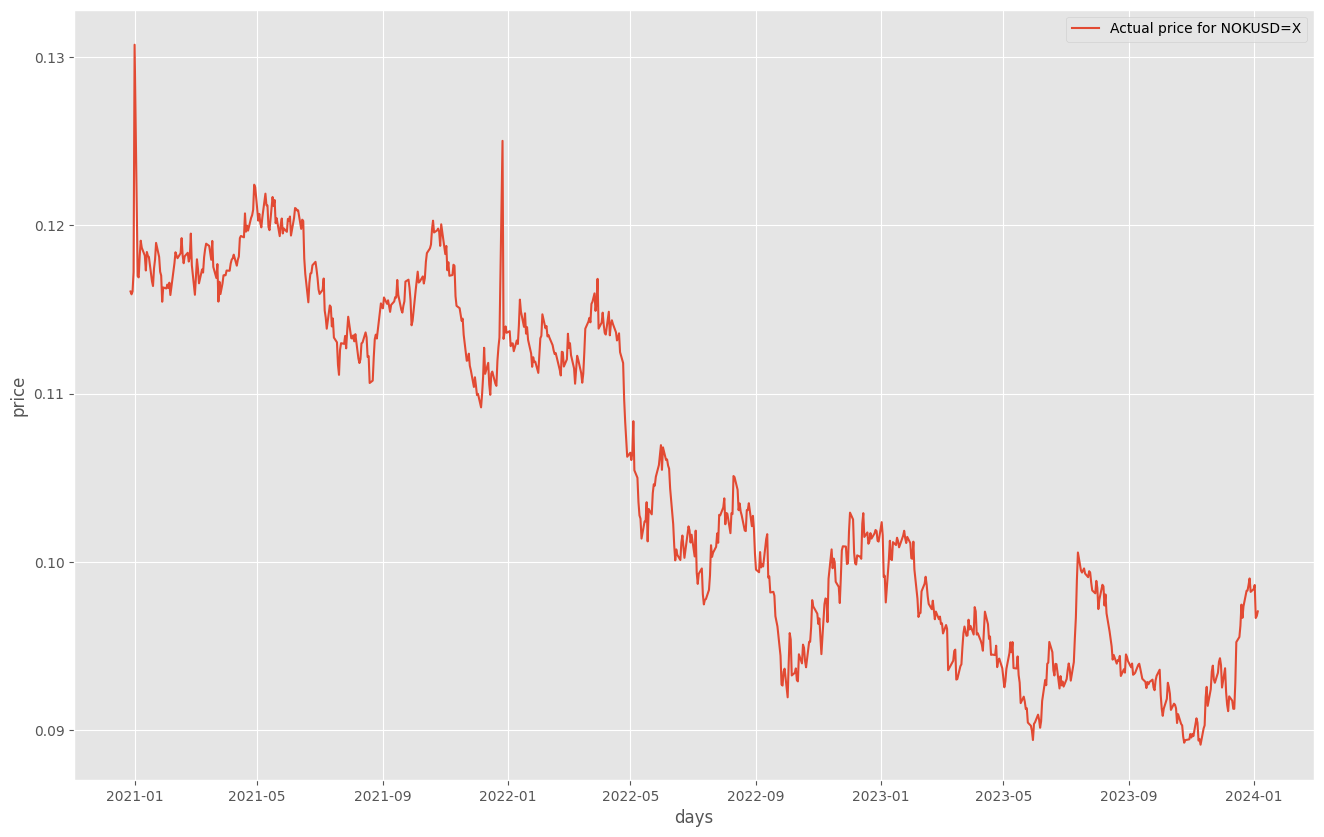

In [7]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

This code snippet normalizes the data in the "close" column of the `init_df` DataFrame, scaling the values to a range between 0 and 1. This normalization is a common preprocessing step for machine learning tasks, especially for models like neural networks, to ensure that large numerical values don't disproportionately influence the model.

1. `scaler = MinMaxScaler()`: Creates an instance of `MinMaxScaler` from `sklearn.preprocessing`. This scaler scales data to a default range of 0 to 1.

2. `np.expand_dims(init_df['close'].values, axis=1)`: Reshapes the 'close' column values from `init_df` to a 2D array, as required by `MinMaxScaler`.

3. `scaler.fit_transform(...)`: Applies the `fit_transform` method of the scaler to the reshaped data. It computes the minimum and maximum values (fit) and then scales the data to the range [0, 1] (transform).

The result is that the 'close' prices in the `init_df` DataFrame are scaled such that the original minimum value becomes 0 and the maximum value becomes 1. This helps stabilize the learning process and improve the performance of the machine learning model.


In [8]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [9]:
init_df

,close,date
2020-12-28,0.647539,2020-12-28
2020-12-29,0.643423,2020-12-29
2020-12-30,0.647546,2020-12-30
2020-12-31,0.675335,2020-12-31
2021-01-01,1.000000,2021-01-01
...,...,...
2024-01-01,0.222378,2024-01-01
2024-01-02,0.228145,2024-01-02
2024-01-03,0.181024,2024-01-03
2024-01-04,0.183917,2024-01-04


This code defines a function `PrepareData(days)` to prepare data for predicting stock prices for a given number of days into the future. Here's a breakdown of its main components and functionality:

1. **Data Copying and Shifting**: 
   - `df = init_df.copy()`: Creates a copy of the initial DataFrame `init_df` to avoid modifying the original data.
   - `df['future'] = df['close'].shift(-days)`: Shifts the 'close' column backward by `days`. This step aligns each current 'close' value with the 'future' value `days` ahead. It's a key part of preparing the data for prediction.

2. **Preparing the Last Sequence**: 
   - `last_sequence = np.array(df[['close']].tail(days))`: Extracts the last `days` number of 'close' values as the final sequence to be used later for making predictions.

3. **Data Cleaning**: 
   - `df.dropna(inplace=True)`: Removes rows with NaN values, which occur due to the shift operation.

4. **Sequence Data Creation**:
   - A deque `sequences` is initialized with a maximum length of `N_STEPS`, ensuring a fixed-size window for the sequences.
   - The loop iterates over the DataFrame, appending each 'close' value and its corresponding date to `sequences`.
   - Once `sequences` reaches its maximum size (`N_STEPS`), it appends a pair of `[sequences, target]` to `sequence_data`, where `target` is the future 'close' value.

5. **Preparing the Final Input Sequence**:
   - The last input sequence is prepared by combining the last elements of `sequences` with `last_sequence`, ensuring it has the correct format and size for prediction.

6. **Constructing Feature and Target Sets (X and Y)**:
   - The loop extracts the sequence (`seq`) and the corresponding future price (`target`) from `sequence_data`, appending them to `X` and `Y`, respectively.
   - `X` (features) contains sequences of stock prices, and `Y` (targets) contains the future stock prices to be predicted.

7. **Conversion to Numpy Arrays**:
   - Converts `X` and `Y` into numpy arrays for compatibility with machine learning models.

8. **Return Values**: 
   - The function returns the modified DataFrame `df`, the `last_sequence` for prediction, and the feature and target sets `X` and `Y`.

In essence, this function prepares the data for a machine learning model, particularly an LSTM model, to predict future stock prices based on historical closing prices.


In [10]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

This code defines a function `GetTrainedModel(x_train, y_train)` which creates and trains a Long Short-Term Memory (LSTM) neural network model for time series prediction, such as stock prices. Here's a breakdown of its key components:

1. **Model Initialization**: 
   - `model = Sequential()`: Initializes a sequential model, indicating the layers of the model will be added in sequence.

2. **First LSTM Layer**:
   - `model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))`: Adds the first LSTM layer with 60 neurons. `return_sequences=True` is specified to ensure the output of this layer includes the sequence information for the next layer. The `input_shape` is set based on the number of steps (`N_STEPS`) and the number of features (`len(['close'])` - here, only the 'close' price).

3. **Dropout Layer**:
   - `model.add(Dropout(0.3))`: Adds a dropout layer that randomly sets 30% of the input units to 0 at each update during training, which helps prevent overfitting.

4. **Second LSTM Layer**:
   - `model.add(LSTM(120, return_sequences=False))`: Adds the second LSTM layer with 120 neurons. `return_sequences=False` indicates that this layer will output a flattened sequence.

5. **Second Dropout Layer**:
   - Another dropout layer with 30% dropout rate is added, serving the same purpose as the first dropout layer.

6. **Dense Layers**:
   - `model.add(Dense(20))`: Adds a dense layer with 20 neurons, which is a standard fully connected neural network layer.
   - `model.add(Dense(1))`: Adds the final dense layer with a single neuron, which outputs the predicted value.

7. **Model Compilation and Training**:
   - `BATCH_SIZE = 8`: Sets the batch size to 8, determining how many samples are used per gradient update.
   - `EPOCHS = 80`: Sets the number of epochs to 80, dictating how many times the learning algorithm will work through the entire training dataset.
   - `model.compile(...)`: Compiles the model with a mean squared error loss function and the Adam optimizer.
   - `model.fit(...)`: Trains the model on the training data (`x_train` and `y_train`) with the specified batch size and epochs.

8. **Model Summary and Return**:
   - `model.summary()`: Prints a summary of the model, showing its architecture and parameters.
   - `return model`: Returns the trained model.

In summary, this function builds a two-layer LSTM neural network with dropout layers to predict time series data, such as stock prices, based on the provided training data.


In [11]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

This code segment is designed to generate stock price predictions for a specified number of days into the future. The process involves preparing the data, training a model, and then using the model to make predictions. Here's a step-by-step explanation:

1. **Initialize Predictions Array**: 
   - `predictions = []`: Initializes an empty list to store the predicted prices.

2. **Loop Through Each Prediction Step**:
   - The loop iterates over `LOOKUP_STEPS`, which contains the days for which predictions are needed (e.g., [1, 2, 3] for predicting 1 day ahead, 2 days ahead, and so on).

3. **Data Preparation**:
   - `df, last_sequence, x_train, y_train = PrepareData(step)`: Calls `PrepareData` function for each `step` in `LOOKUP_STEPS`. This function prepares the data suitable for the prediction model.
   - `x_train = x_train[:, :, :len(['close'])].astype(np.float32)`: Formats the `x_train` data to ensure it has the correct dimensions and type for the model.

4. **Model Training**:
   - `model = GetTrainedModel(x_train, y_train)`: Trains the LSTM model using the prepared training data.

5. **Prepare Last Sequence for Prediction**:
   - `last_sequence = last_sequence[-N_STEPS:]`: Extracts the last `N_STEPS` from `last_sequence` to align with the model's input requirement.
   - `last_sequence = np.expand_dims(last_sequence, axis=0)`: Reshapes `last_sequence` to fit the model's expected input shape.

6. **Model Prediction**:
   - `prediction = model.predict(last_sequence)`: Uses the trained model to predict the future stock price based on the `last_sequence`.
   - `predicted_price = scaler.inverse_transform(prediction)[0][0]`: Inverse transforms the predicted value back to the original price scale (since the data was likely normalized before training).

7. **Store Prediction**:
   - `predictions.append(round(float(predicted_price), 4))`: Rounds the predicted price to 4 decimal places and appends it to the `predictions` list.

In summary, the script iteratively prepares training data, trains an LSTM model, and makes stock price predictions for each specified future day. The predictions are stored in an array, providing a forecast for the upcoming days specified in `LOOKUP_STEPS`.


In [12]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 4))

Epoch 1/80
98/98 [==============================] - 4s 11ms/step - loss: 0.0104
Epoch 2/80
98/98 [==============================] - 1s 10ms/step - loss: 0.0032
Epoch 3/80
98/98 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 4/80
98/98 [==============================] - 1s 9ms/step - loss: 0.0026
Epoch 5/80
98/98 [==============================] - 1s 9ms/step - loss: 0.0031
Epoch 6/80
98/98 [==============================] - 1s 10ms/step - loss: 0.0023
Epoch 7/80
98/98 [==============================] - 1s 8ms/step - loss: 0.0022
Epoch 8/80
98/98 [==============================] - 1s 8ms/step - loss: 0.0022
Epoch 9/80
98/98 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 10/80
98/98 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 11/80
98/98 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 12/80
98/98 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 13/80
98/98 [===========================

Check the predictions

In [13]:
predictions

[0.097, 0.0974, 0.0971]

This code segment is for executing a trained model on the entire historical data range and adding the model's predictions back into a DataFrame. Here's a step-by-step explanation:

1. **Create a Copy of the Original DataFrame**:
   - `copy_df = init_df.copy()`: Creates a copy of the original DataFrame `init_df` to keep the original data unmodified.

2. **Predict Using the Model**:
   - `y_predicted = model.predict(x_train)`: Uses the trained model to predict values based on `x_train`.

3. **Inverse Transform of Predictions**:
   - `y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))`: Inverse transforms the normalized predictions to their original scale.

4. **Handling Edge Cases for Continuity**:
   - `first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))`: Inverse transforms the first six values of `y_train` to their original scale.
   - `last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))`: Similarly, inverse transforms the last three values of `y_train`.
   - These steps ensure the continuity and completeness of the transformed predictions.

5. **Appending Edge Cases to Predictions**:
   - `y_predicted_transformed = np.append(first_seq, y_predicted_transformed)`: Appends the first sequence to the beginning of the predicted values.
   - `y_predicted_transformed = np.append(y_predicted_transformed, last_seq)`: Appends the last sequence to the end of the predicted values.

6. **Adding Predictions to DataFrame**:
   - `copy_df[f'predicted_close'] = y_predicted_transformed`: Adds the complete set of transformed predictions to `copy_df` under the column 'predicted_close'.

7. **Inverse Transform of Original Close Prices**:
   - `copy_df[f'close'] = scaler.inverse_transform(np.expand_dims(copy_df['close'].values, axis=1))`: Inverse transforms the normalized 'close' prices in `copy_df` to their original scale.

In summary, this script executes the model on historical data, processes the predictions for continuity, and updates the copied DataFrame with both the predicted and actual stock prices in their original scales.


In [14]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed
copy_df[f'close'] = scaler.inverse_transform(np.expand_dims(copy_df['close'].values, axis=1))
copy_df

25/25 [==============================] - 0s 4ms/step


,close,date,predicted_close
2020-12-28,0.116071,2020-12-28,0.118670
2020-12-29,0.115900,2020-12-29,0.118195
2020-12-30,0.116071,2020-12-30,0.117315
2020-12-31,0.117226,2020-12-31,0.118412
2021-01-01,0.130723,2021-01-01,0.118185
...,...,...,...
2024-01-01,0.098397,2024-01-01,0.098611
2024-01-02,0.098637,2024-01-02,0.098697
2024-01-03,0.096678,2024-01-03,0.096678
2024-01-04,0.096798,2024-01-04,0.096798


This code segment adds the predicted future stock prices for the next three days to a DataFrame. It shows how to append new rows with the predicted data. Here's a breakdown of the process:

1. **Determine Future Dates**:
   - `date_now = dt.date.today()`: Retrieves the current date.
   - `date_tomorrow = dt.date.today() + dt.timedelta(days=1)`: Calculates the date for the next day.
   - `date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)`: Calculates the date for two days from now.

2. **Display Last Few Rows of the DataFrame**:
   - `print(copy_df.tail())`: Prints the last few rows of `copy_df` for reference.

3. **Print Predicted Price for the Current Date**:
   - `print([predictions[0], f'{date_now}', 0, 0])`: Prints the predicted price for the current date along with the date.

4. **Add Predictions to the DataFrame**:
   - `copy_df.loc[f'{date_now} 00:00:00'] = [0, f'{date_now}', predictions[0]]`: Adds a new row to `copy_df` for the current date with the corresponding predicted price.
   - `copy_df.loc[f'{date_tomorrow} 00:00:00'] = [0, f'{date_tomorrow}', predictions[1]]`: Adds a new row for the next day with its prediction.
   - `copy_df.loc[f'{date_after_tomorrow} 00:00:00'] = [0, f'{date_after_tomorrow}', predictions[2]]`: Adds a new row for two days from now with its prediction.

5. **Display the Updated DataFrame**:
   - `copy_df.tail()`: Shows the last few rows of `copy_df`, including the newly added rows with future predictions.

In summary, this script appends new rows to the `copy_df` DataFrame with future dates and their corresponding predicted stock prices, effectively extending the dataset with forecasted data.


In [15]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)
print(copy_df.tail())
print([predictions[0], f'{date_now}', 0, 0])
copy_df.loc[f'{date_now} 00:00:00'] = [0, f'{date_now}', predictions[0]]
copy_df.loc[f'{date_tomorrow} 00:00:00'] = [0, f'{date_tomorrow}', predictions[1]]
copy_df.loc[f'{date_after_tomorrow} 00:00:00'] = [0, f'{date_after_tomorrow}', predictions[2]]
copy_df.tail()


               close       date  predicted_close
2024-01-01  0.098397 2024-01-01         0.098611
2024-01-02  0.098637 2024-01-02         0.098697
2024-01-03  0.096678 2024-01-03         0.096678
2024-01-04  0.096798 2024-01-04         0.096798
2024-01-05  0.097071 2024-01-05         0.097071
[0.097, '2024-01-05', 0, 0]


,close,date,predicted_close
2024-01-03 00:00:00,0.096678,2024-01-03 00:00:00,0.096678
2024-01-04 00:00:00,0.096798,2024-01-04 00:00:00,0.096798
2024-01-05 00:00:00,0.000000,2024-01-05 00:00:00,0.097000
2024-01-06 00:00:00,0.000000,2024-01-06,0.097400
2024-01-07 00:00:00,0.000000,2024-01-07,0.097100


This code segment creates a plot to visualize the actual and predicted stock prices, including predictions for future dates. It showcases the model's performance and its forecasts. Here's a breakdown of the plotting process:

1. **Set Plot Style**:
   - `plt.style.use(style='ggplot')`: Sets the plotting style to 'ggplot', which is a popular style for making the plots more visually appealing.

2. **Initialize Figure**:
   - `plt.figure(figsize=(16,10))`: Initializes a new figure for plotting with a specified size of 16x10 inches.

3. **Plot Actual Prices**:
   - `plt.plot(copy_df['close'][-150:].head(147))`: Plots the actual closing prices from the last 150 days, excluding the last 3 days (147 days in total).

4. **Plot Predicted Prices (Historical)**:
   - `plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')`: Plots the predicted closing prices for the same historical period as the actual prices. The line is dashed and thinner for differentiation.

5. **Plot Predictions for Future Dates**:
   - `plt.plot(copy_df['predicted_close'][-150:].tail(4))`: Plots the predicted prices for the last 3 future days.

6. **Add Labels and Legend**:
   - `plt.xlabel('days')` and `plt.ylabel('price')`: Labels the x-axis as 'days' and the y-axis as 'price'.
   - `plt.legend(...)`: Adds a legend to the plot, distinguishing between actual prices, predicted historical prices, and future price predictions.

7. **Display the Plot**:
   - `plt.show()`: Renders and displays the plot.

In summary, this script visualizes the actual vs. predicted stock prices for the specified stock symbol (`STOCK`), including predictions for the next three days, effectively illustrating the model's accuracy and its predictive capabilities.


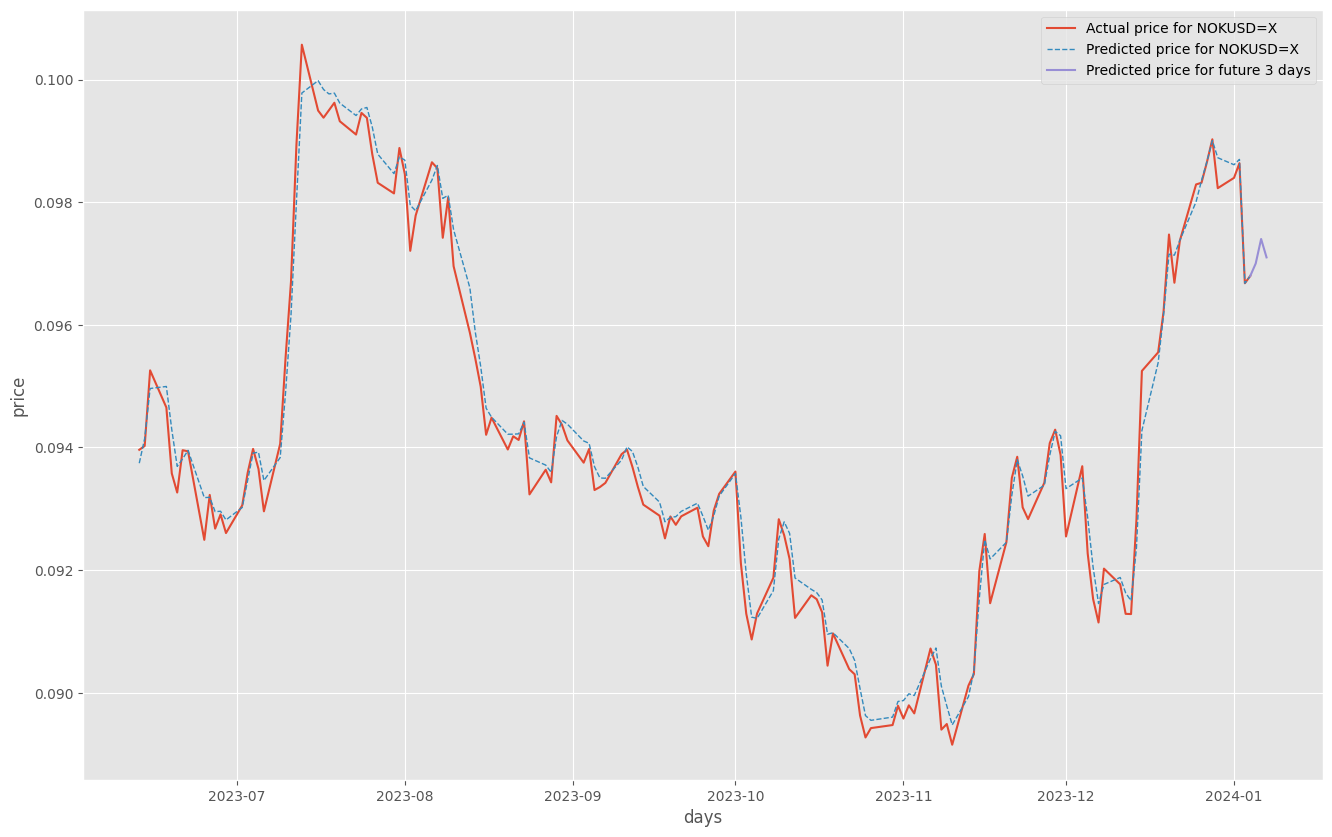

In [16]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['predicted_close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()